In [258]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
import scipy as sp
import json
from scipy.fft import fft, fftfreq

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load experiments

In [2]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.amplitude_rabi_ef
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_ef_spectroscopy
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.ramsey_ef
imported experiments.single_qubit.randbench
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_echo
imported experiments.single_qubit.t2_ramsey
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.length_rabi_EgGf
imported experiments.two_qubit.pulse_probe_EgGf_spectroscopy
imported experiments.two_qubit.twoqutrit_state_tomography
imported experiments.two_qubit.twoQ_state_tomography


In [3]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'/'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [4]:
expt_path=os.getcwd()+'\data'
print('Data will be stored in', expt_path)

Data will be stored in s:\Connie\experiments\220623_qram\data


In [5]:
# config_file = 'config_zcu216.yml'
config_file = 'config_q3diamond.yml'
config_path = os.getcwd() + '\\' + config_file
print('Config will be', config_path)

Config will be s:\Connie\experiments\220623_qram\config_q3diamond.yml


# Qubit/resonator to probe

In [461]:
qubit_i = 0

# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [259]:
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [430]:
im = InstrumentManager()

In [260]:
lo1 = im[yaml_cfg.aliases.readout_LO]
lo1.open_device()
print(lo1.get_id())

# # TURN OFF
# lo1.set_standby(True)
# lo1.set_output_state(False)

# TURN ON
lo1.set_standby(False)
lo1.set_output_state(True)
lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
lo_power = float(yaml_cfg.hw.lo.readout.power)
lo1.set_frequency(lo_freq) # Set LO frequency
print('set freq to', lo_freq)
lo1.set_power(lo_power) # Set LO power
print('set power to', lo_power)

Default Instrument SC_26C1
set freq to 6100000000.0
set power to 10.0


In [431]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())


QICK configuration:

	Board: ZCU216

	Global clocks (MHz): tProcessor 349.997, RF reference 245.760

	7 signal generator channels:
	0:	axis_sg_int4_v1 - tProc output 0, switch ch 0, maxlen 4096
		DAC tile 2, ch 0, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	1:	axis_sg_int4_v1 - tProc output 1, switch ch 1, maxlen 4096
		DAC tile 2, ch 1, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	2:	axis_sg_int4_v1 - tProc output 2, switch ch 2, maxlen 4096
		DAC tile 2, ch 2, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	3:	axis_sg_int4_v1 - tProc output 3, switch ch 3, maxlen 4096
		DAC tile 2, ch 3, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	4:	axis_signal_gen_v6 - tProc output 4, switch ch 4, maxlen 65536
		DAC tile 3, ch 0, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	5:	axis_signal_gen_v6 - tProc output 5, switch ch 5, maxlen 65536
		DAC tile 3, ch 1, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	6:	axis_sg_mux4_v2 - tProc output 6, switch ch -1, maxlen 0
		DAC tile 0,

# RFSoC Calibration

In [315]:
pulse_length =      soc.us2cycles(9.9, gen_ch=6)
readout_length =    soc.us2cycles(9.9, ro_ch=0)
print(soc.cycles2us(95, gen_ch=6))
print(soc.cycles2us(95, ro_ch=0))
print(soc.us2cycles(soc.cycles2us(95, gen_ch=6), ro_ch=0))
print(pulse_length, readout_length, readout_length-pulse_length)

0.22088913690476192
0.3092447916666667
68
4258 3041 -1217


In [10]:
tof = meas.ToFCalibrationExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"adc_trig_offset_calibration_qubit{qubit_i}",
    config_file=config_path,
)

tof.cfg.expt = dict(
    pulse_length=1, # [us]
    readout_length=2, # [us]
    trig_offset=0, # [clock ticks]
    # gain=32000,
    gain=1.0, # [MUX units: -1 to 1]
    frequency=tof.cfg.device.readout.frequency[qubit_i], # [MHz]
    reps=500, # Number of averages per point
    # qubit=qubit_i,
    qubit=qubit_i,
)
tof.cfg.device.readout.relax_delay=0.1 # wait time between experiments [us]
print(tof.cfg)
tof.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [50, 50, 50, 50], 'f_ge': [843.35, 3477.15, 167.6, 458], 'f_ef': [200, 200, 200, 200], 'f_EgGf': [2000, 0, 2000, 2000], 'pulses': {'pi_ge': {'gain': [10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_ef': {'gain': [10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_EgGf': {'gain': [10000, 0, 10000, 10000], 'sigma': [0.1, 0, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'trig_offset': 120, 'frequency': [600.9, -665.3, -292.1, -130.4], 'gain': [0.085, 0.03, 0.025, 0.02], 'phase': [0, 0, 0, 0], 'threshold_ge': [0, 0, 0, 0], 'threshold_ef': [0, 0, 0, 0], 'readout_length': [5, 5, 5, 5], 'relax_delay': 0.1}}, 'hw': {'lo': {'readout': {'frequency': '6.1e9', 'power': 10}}, 'soc': {'dacs': {'qubit': {'ch': [0, 5, 0, 0], 'type': ['int4', 'full', 'int4', 'int4'], 'mixer_freq': [4000, 0, 4000, 4000], 'nyquist': [2, 2, 2, 2]}, 'swap': {'ch': [4, -1, 4, 4], 'type': ['full', 'None', 'full', 'full'], 'nyquist': [1,

  0%|          | 0/500 [00:00<?, ?it/s]

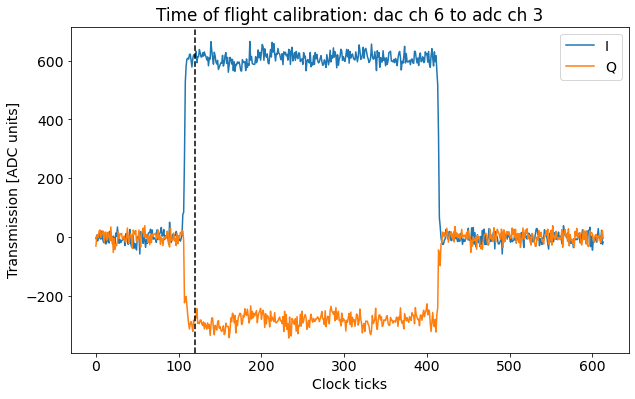

In [11]:
tof.display(adc_trig_offset=120)

In [131]:
tof.save_data()

Saving s:\Connie\experiments\202201xx_2Transmon_Connie/data\00000_adc_trig_offset_calibration_qubit1.h5


# Resonator spectroscopy

## Single tone (resonator) spectroscopy

Measures the resonant frequency of the readout resonator when the qubit is in its ground state: sweep readout pulse frequency and look for the frequency with the maximum measured amplitude.

The resonator frequency should be stored in the parameter <code>cfg.device.readouti.frequency</code>.

Note that harmonics of the clock frequency (6144 MHz) will show up as "infinitely"  narrow peaks!


In [357]:
rspec = meas.ResonatorSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"resonator_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

span = 2.5 # MHz
npts = 151
# arduino.set_voltage(channel=4, voltage=0.0104)
rspec.cfg.expt = dict(
    start=rspec.cfg.device.readout.frequency[qubit_i]-span/2, # resonator frequency to be mixed up [MHz]
    # start=rspec.cfg.device.readout.frequency[qubit_i]-0.75*span,
    # start=rspec.cfg.device.readout.frequency[qubit_i]-0.25*span,
    # start=0,
    step=span/npts, # min step ~1 Hz
    expts=npts, # Number experiments stepping from start
    reps=2000, # Number averages per point
    pulse_e=False, # add ge pi pulse prior to measurement
    pulse_f=False, # add ef pi pulse prior to measurement
    qubit=qubit_i,
)

# rspec.cfg.device.readout.gain = 0.07

# rspec.cfg.device.readout.relax_delay = 5 # Wait time between experiments [us]
# rspec.cfg.device.readout.readout_length = 5
print(rspec.cfg)
rspec.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [35, 80, 50, 44], 'f_ge': [845.0, 3478.17, 168.08, 465.8], 'pulses': {'pi_ge': {'gain': [10585, 13251, 13657, 12683], 'sigma': [0.035, 0.03, 0.02, 0.015], 'type': 'gauss'}}}, 'readout': {'trig_offset': 120, 'frequency': [600.9, -665.3, -292.1, -130.4], 'gain': [0.085, 0.03, 0.025, 0.07], 'readout_length': [5, 5, 5, 5], 'relax_delay': [120, 320, 200, 200]}}, 'hw': {'lo': {'readout': {'frequency': '6.1e9', 'power': 10}}, 'soc': {'dacs': {'qubit': {'ch': [0, 5, 0, 0], 'type': ['int4', 'full', 'int4', 'int4'], 'mixer_freq': [4000, 0, 4000, 4000], 'nyquist': [2, 2, 2, 2]}, 'swap': {'ch': [4, -1, 4, 4], 'type': ['full', 'None', 'full', 'full'], 'nyquist': [1, 0, 1, 1]}, 'readout': {'ch': 6, 'type': 'mux4', 'mixer_freq': 985, 'nyquist': 1}}, 'adcs': {'readout': {'ch': [0, 1, 2, 3]}}}}, 'aliases': {'readout_LO': 'SC_26C1', 'soc': 'Qick187'}, 'expt': {'start': -131.65, 'step': 0.016556291390728478, 'expts': 151, 'reps': 2000, 'pulse_e': False, 'pulse_f': False, 'qubi

  0%|          | 0/151 [00:00<?, ?it/s]


Freq with minimum transmission: -130.0771523178808
From fit:
	f0: -130.3582463664497
	Qi: 992.706297377605
	Qe: 638.9590559975999
	Q0: 388.7431190122285
	kappa [MHz]: -0.33533261424068855
	phi [radians]: -1.2375328379316888


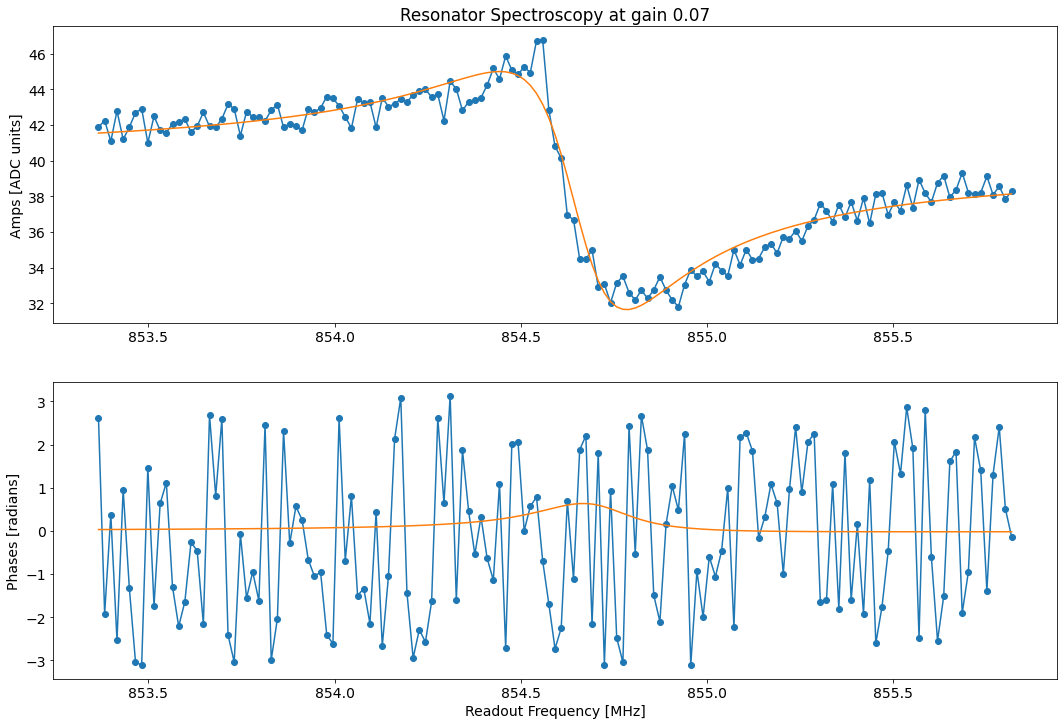

In [358]:
# # TESTING
# rspec = meas.ResonatorSpectroscopyExperiment(config_file=config_path,) 
# # temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit1.h5')
# temp_data, attrs = prev_data(expt_path, '00000_power_sweep_resonator_spectroscopy_qubit0.h5')
# i_gain = np.argmin(np.abs(temp_data['gainpts']-30))
# temp_data['amps'] = temp_data['amps'][i_gain][80:]
# temp_data['xpts'] = temp_data['xpts'][80:]
# data = rspec.analyze(data=temp_data, fit=True)
# rspec.display(data=data, fit=True)

rspec.analyze(fit=True, findpeaks=False)
rspec.display(fit=True, findpeaks=False)

In [343]:
rspec.save_data()

Saving s:\Connie\experiments\220623_qram\data\00002_resonator_spectroscopy_qubit2.h5


## Power sweep resonator spectroscopy

Repeat resonator spectroscopy at a range of powers to check that resonator frequency shifts at low powers. (Check qubit is alive.)

Use this experiment to determine the appropriate resonator gain, which should be stored in <code>cfg.device.readout.gain</code>


In [6]:
rpowspec = meas.ResonatorPowerSweepSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"power_sweep_resonator_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

span_f = 8.0
npts_f = 301

span_gain = 0.2
npts_gain = 50

rpowspec.cfg.expt = dict(
    start_f=rpowspec.cfg.device.readout.frequency[qubit_i]-span_f*0.75, # Resonator frequency to be mixed up [MHz]
    step_f=span_f/npts_f, # min step ~1 Hz
    expts_f=npts_f, # Number experiments stepping freq from start
    # start_gain=rpowspec.cfg.device.readout.gain[qubit_i], # Gain sweep start [DAC units]
    start_gain=0,
    step_gain=int(span_gain/npts_gain), # Gain step size
    expts_gain=npts_gain, # Number experiments stepping gain from start
    reps=5000, # Number averages per point
    pi_pulse=False, # add pi pulse before measurement
    qubit=qubit_i,
)
rpowspec.cfg.device.readout.relax_delay = 10 # Wait time between experiments [us]

print(rpowspec.cfg)

rpowspec.go(analyze=False, display=False, progress=True, save=False)

NameError: name 'soc' is not defined

Extracted data and attrs ['config']


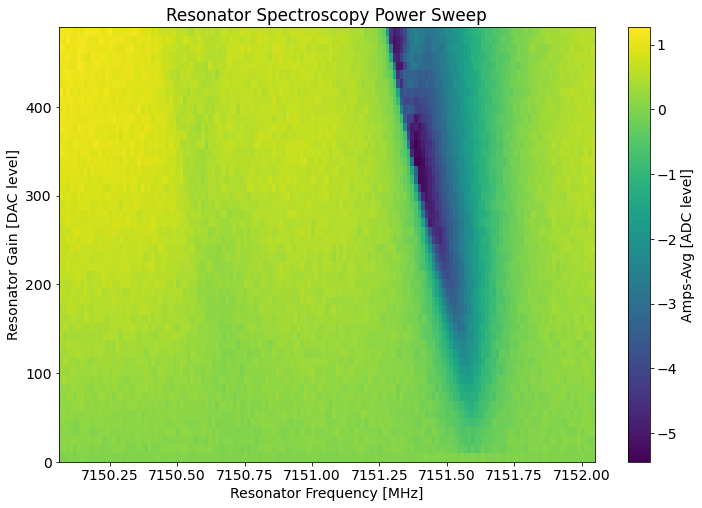

In [40]:
# TESTING
rpowspec = meas.ResonatorPowerSweepSpectroscopyExperiment(config_file=config_path)
temp_data, attrs = prev_data(expt_path, '00000_power_sweep_resonator_spectroscopy_qubit1.h5')
rpowspec.display(data=temp_data, fit=False)

# rpowspec.analyze(fit=False, lowgain=150, highgain=None)
# rpowspec.display(fit=False)

In [533]:
rpowspec.save_data()

Saving s:\Connie\experiments\20220430_2Transmon\data\00000_power_sweep_resonator_spectroscopy_qubit1.h5


# Qubit ge spectroscopy

## Pulse Probe (qubit) spectroscopy

Measures the qubit frequency f_ge by driving at resonator frequency and sweeping qubit frequency.

Qubit frequency should be stored in <code>cfg.qubiti.f_ge</code>.

In [451]:
qspec = meas.PulseProbeSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

span = 300
npts = 200

qspec.cfg.expt = dict(
    # start=qspec.cfg.device.qubit.f_ge[qubit_i]-span/2, # resonator frequency to be mixed up [MHz]
    start=qspec.cfg.device.qubit.f_ge[qubit_i]-0.75*span, # resonator frequency to be mixed up [MHz]
    # start=3000,
    step=span/npts, # min step ~1 MHz
    expts=npts, # Number of experiments stepping from start
    reps=300, # Number of averages per point
    rounds=20, # Number of start to finish sweeps to average over
    length=15, # Qubit probe constant pulse length [us]
    gain=5000, # Qubit pulse gain
    qubit=qubit_i,
)
qspec.cfg.device.readout.relax_delay = 10 # Wait time between experiments [us]

print(qspec.cfg)

qspec.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [35, 80, 50, 44], 'f_ge': [845.0, 3478.17, 168.08, 465.8], 'f_ef': [656.8, 3377, 121, 290], 'pulses': {'pi_ge': {'gain': [10585, 13251, 13657, 12683], 'sigma': [0.035, 0.03, 0.02, 0.015], 'type': 'gauss'}}}, 'readout': {'trig_offset': 120, 'frequency': [600.9, -665.3, -292.1, -130.4], 'gain': [0.085, 0.03, 0.025, 0.07], 'readout_length': [5, 5, 5, 5], 'relax_delay': 10}}, 'hw': {'lo': {'readout': {'frequency': '6.1e9', 'power': 10}}, 'soc': {'dacs': {'qubit': {'ch': [0, 5, 0, 0], 'type': ['int4', 'full', 'int4', 'int4'], 'mixer_freq': [4000, 0, 4000, 4000], 'nyquist': [2, 2, 2, 2]}, 'swap': {'ch': [4, -1, 4, 4], 'type': ['full', 'None', 'full', 'full'], 'nyquist': [1, 0, 1, 1]}, 'readout': {'ch': 6, 'type': 'mux4', 'mixer_freq': 985, 'nyquist': 1}}, 'adcs': {'readout': {'ch': [0, 1, 2, 3]}}}}, 'aliases': {'readout_LO': 'SC_26C1', 'soc': 'Qick187'}, 'expt': {'start': -56.91999999999999, 'step': 1.5, 'expts': 200, 'reps': 300, 'rounds': 20, 'length': 15, 'gain

  0%|          | 0/20 [00:00<?, ?it/s]

Found peak in I at [MHz] 6.937522828189833, HWHM 91.49388005541442
Found peak in Q at [MHz] 8.675206372747477, HWHM 97.43804883454146


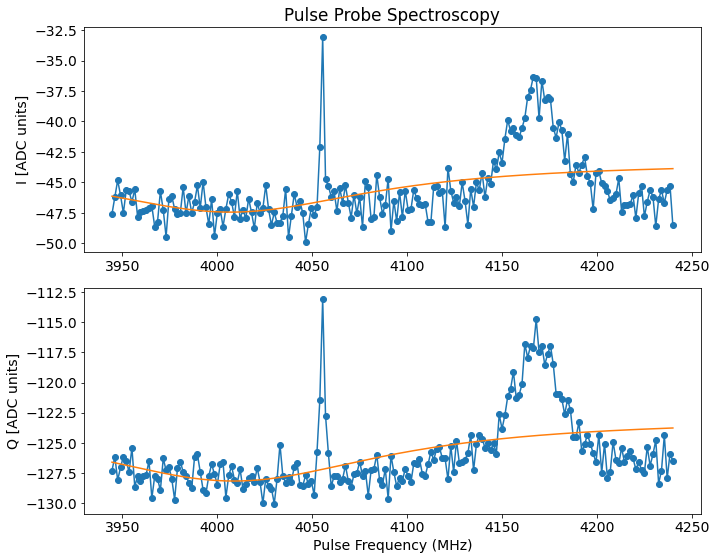

In [452]:
# # TESTING
# qspec = meas.PulseProbeSpectroscopyExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00001_qubit_spectroscopy_qubit1.h5')
# temp_data['avgi'] = temp_data['amps']
# data = qspec.analyze(data=temp_data, fit=True)
# qspec.display(data=data, fit=True)

qspec.analyze(fit=True, signs=[1, -1])
qspec.display(fit=True, signs=[1, -1])

In [25]:
qspec.save_data()

Saving s:\Connie\experiments\220623_qram\data\00000_qubit_spectroscopy_qubit3.h5


## Length Rabi

Measures Rabi oscillations by sweeping over the duration of the qubit drive pulse. This is a preliminary measurement to prove that we see Rabi oscillations. This measurement is followed up by the Amplitude Rabi experiment below.


In [28]:
soc.cycles2us(5*50)

0.7142928572142864

In [290]:
lengthrabi = meas.LengthRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"length_rabi_qubit{qubit_i}",
    config_file=config_path,
)

lengthrabi.cfg.expt = dict(
    start=0, # pulse length (sigma) [us]
    step=soc.cycles2us(1), # [us]
    # step=0.001,
    expts=40,
    reps=2000,
    gain=20000, # qubit gain [DAC units],
    pulse_type='gauss',
    qubit=qubit_i,
)
lengthrabi.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]

print(lengthrabi.cfg)
# lengthrabi.im[lengthrabi.cfg.aliases.soc].reset()
lengthrabi.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [35, 80, 50, 50], 'f_ge': [845, 3478.17, 168.08, 465.8], 'f_ef': [200, 200, 200, 200], 'f_EgGf': [2000, 0, 2000, 2000], 'pulses': {'pi_ge': {'gain': [10585, 13251, 13657, 10000], 'sigma': [0.035, 0.03, 0.02, 0.1], 'type': 'gauss'}, 'pi_ef': {'gain': [10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_EgGf': {'gain': [10000, 0, 10000, 10000], 'sigma': [0.1, 0, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'trig_offset': 120, 'frequency': [600.9, -665.3, -292.1, -130.4], 'gain': [0.085, 0.03, 0.025, 0.07], 'phase': [0, 0, 0, 0], 'threshold_ge': [0, 0, 0, 0], 'threshold_ef': [0, 0, 0, 0], 'readout_length': [5, 5, 5, 5], 'relax_delay': 100}}, 'hw': {'lo': {'readout': {'frequency': '6.1e9', 'power': 10}}, 'soc': {'dacs': {'qubit': {'ch': [0, 5, 0, 0], 'type': ['int4', 'full', 'int4', 'int4'], 'mixer_freq': [4000, 0, 4000, 4000], 'nyquist': [2, 2, 2, 2]}, 'swap': {'ch': [4, -1, 4, 4], 'type': ['full', 'None', 'full', 'full'], 'nyquist':

  0%|          | 0/40 [00:00<?, ?it/s]

Pi length from avgi data [us]: 0.008736053073016744
Pi/2 length from avgi data [dac units]: 0.004368026536508372
Pi length from avgq data [us]: 0.0032227505019371498
Pi/2 length from avgq data [dac units]: 0.0016113752509685749


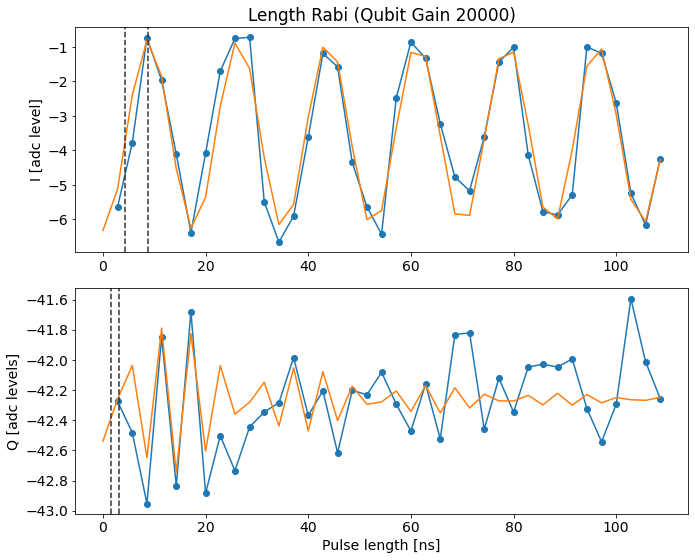

In [291]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = lengthrabi.analyze(data=temp_data, fit=True)

lengthrabi.analyze(fit=True)
lengthrabi.display(fit=True)

In [292]:
lengthrabi.save_data()

Saving s:\Connie\experiments\220623_qram\data\00000_length_rabi_qubit3.h5


## Amplitude Rabi

Measures Rabi oscillations by sweeping over the amplitude of the qubit drive pulse, which is a Gaussian pulse with sigma set by <code>cfg.device.qubiti.pulses.pi_ge.sigma</code>. We measure the $\pi$ pulse amplitude which are used in subsequent experiments to control the qubit, which should be stored in <code>cfg.device.qubiti.pulses.pi_ge.gain</code>.

In [294]:
amprabi = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"amp_rabi_qubit{qubit_i}",
    config_file=config_path,
)

span = 32000
npts = 101
    
amprabi.cfg.expt = dict(
    start=0, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=100,
    rounds=100,
    sigma_test=0.015, # gaussian sigma for pulse length - overrides config [us]
    pulse_type='gauss',
    qubit=qubit_i,
)

amprabi.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]

print(amprabi.cfg)

amprabi.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [35, 80, 50, 50], 'f_ge': [845, 3478.17, 168.08, 465.8], 'f_ef': [200, 200, 200, 200], 'f_EgGf': [2000, 0, 2000, 2000], 'pulses': {'pi_ge': {'gain': [10585, 13251, 13657, 10000], 'sigma': [0.035, 0.03, 0.02, 0.1], 'type': 'gauss'}, 'pi_ef': {'gain': [10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_EgGf': {'gain': [10000, 0, 10000, 10000], 'sigma': [0.1, 0, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'trig_offset': 120, 'frequency': [600.9, -665.3, -292.1, -130.4], 'gain': [0.085, 0.03, 0.025, 0.07], 'phase': [0, 0, 0, 0], 'threshold_ge': [0, 0, 0, 0], 'threshold_ef': [0, 0, 0, 0], 'readout_length': [5, 5, 5, 5], 'relax_delay': 100}}, 'hw': {'lo': {'readout': {'frequency': '6.1e9', 'power': 10}}, 'soc': {'dacs': {'qubit': {'ch': [0, 5, 0, 0], 'type': ['int4', 'full', 'int4', 'int4'], 'mixer_freq': [4000, 0, 4000, 4000], 'nyquist': [2, 2, 2, 2]}, 'swap': {'ch': [4, -1, 4, 4], 'type': ['full', 'None', 'full', 'full'], 'nyquist':

  0%|          | 0/100 [00:00<?, ?it/s]

fitparam 1 is init to 0.000379746835443038, out of bounds
Pi gain from avgi data [dac units]: 12683
	Pi/2 gain from avgi data [dac units]: 6341
Pi gain from avgq data [dac units]: 2851
	Pi/2 gain from avgq data [dac units]: 1425


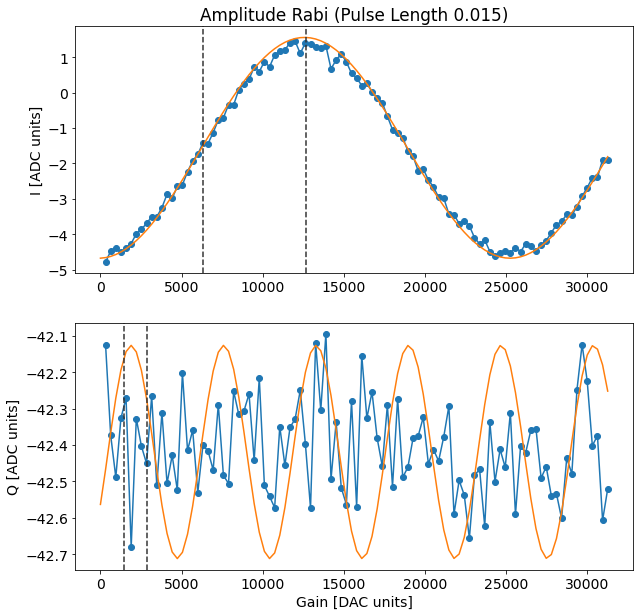

In [295]:
# # TESTING
# amprabi = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00001_amp_rabi_qubit1.h5')
# data = amprabi.analyze(data=temp_data, fit=True)
# amprabi.display(data=data, fit=True)

amprabi.analyze(fit=True)
amprabi.display(fit=True)

In [296]:
amprabi.save_data()

Saving s:\Connie\experiments\220623_qram\data\00000_amp_rabi_qubit3.h5


## Amplitude rabi qubit frequency sweep (chevron)

In [ ]:
amprabichev = meas.AmplitudeRabiChevronExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"amp_rabi_qubit_chevron{qubit_i}",
    config_file=config_path,
)

span_gain = 32000
npts_gain = 3

span_f = 5
npts_f = 5

amprabichev.cfg.expt = dict(
    start_f=4315,
    step_f=span_f/npts_f,
    expts_f=npts_f,
    start_gain=0, # qubit gain [dac level]
    step_gain=int(span_gain/npts_gain), # [dac level]
    expts_gain=npts_gain,
    reps=50,
    rounds=10,
    sigma_test=0.2, # gaussian sigma for pulse length - overrides config [us]
    pulse_type='gauss',
    qubit=qubit_i,
)

amprabichev.cfg.device.readout.relax_delay = 50 # Wait time between experiments [us]

print(amprabichev.cfg)

amprabichev.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
# # TESTING
# temp_data_file = '/home/xilinx/jupyter_notebooks/_experiment/20211215_LL_StandardCandle1/data/00000_power_sweep_resonator_spectroscopy_qubit2.h5'
# with SlabFile(temp_data_file) as a:
#     temp_data = dict(
#         amps=np.asarray(a['amps']),
#         gainpts=np.asarray(a['gain']),
#         fpts=np.asarray(a['freq']),
#     )

# data = rpowspec.analyze(data=temp_data, lowgain=2000, highgain=18000)

amprabichev.analyze()
amprabichev.display()

In [ ]:
amprabichev.save_data()

## Single Shot

Measures the single shot readout fidelity of the system. We acquire single shot (I, Q) readout values by first preparing the qubit in its ground (blue dots) a certain number of times and then preparing the qubit in its excited state (red dots) the same number of times. We then extract two parameters which are used to optimize the associated readout fidelity: the rotation angle of the IQ blobs and the threshold that classifies the two qubit states (ground and excited). The two output parameters should be stored in <code>cfg.device.readouti.phase</code> and <code>cfg.device.readouti.threshold</code>.

Note that this experiment already assumes that you have found your qubit frequency and $\pi$ pulse amplitude. Every time you reset the QICK firmware the single shot angle and threshold changes. So, this experiment is used to calibrate any experiment below that uses single shot data (such as the Active Reset experiment).

In [334]:
shot = meas.HistogramExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_qubit{qubit_i}",
    config_file=config_path,
)

shot.cfg.expt = dict(
    reps=50000,
    check_f=False,
    qubit=qubit_i,
)

# shot.cfg.device.readout.frequency=1751.5253727591987 
# shot.cfg.device.readout.gain=270
# shot.cfg.device.readout.readout_length = 16 # [us]
# shot.cfg.device.readout.relax_delay = 70 # Wait time between experiments [us]
print(shot.cfg)

shot.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [35, 80, 50, 44], 'f_ge': [845.0, 3478.17, 168.08, 465.8], 'pulses': {'pi_ge': {'gain': [10585, 13251, 13657, 12683], 'sigma': [0.035, 0.03, 0.02, 0.015], 'type': 'gauss'}}}, 'readout': {'trig_offset': 120, 'frequency': [600.9, -665.3, -292.1, -130.4], 'gain': [0.085, 0.03, 0.025, 0.07], 'phase': [0, 0, 0, 0], 'threshold_ge': [0, 0, 0, 0], 'threshold_ef': [0, 0, 0, 0], 'readout_length': [5, 5, 5, 5], 'relax_delay': [100, 240, 150, 210]}}, 'hw': {'lo': {'readout': {'frequency': '6.1e9', 'power': 10}}, 'soc': {'dacs': {'qubit': {'ch': [0, 5, 0, 0], 'type': ['int4', 'full', 'int4', 'int4'], 'mixer_freq': [4000, 0, 4000, 4000], 'nyquist': [2, 2, 2, 2]}, 'swap': {'ch': [4, -1, 4, 4], 'type': ['full', 'None', 'full', 'full'], 'nyquist': [1, 0, 1, 1]}, 'readout': {'ch': 6, 'type': 'mux4', 'mixer_freq': 985, 'nyquist': 1}}, 'adcs': {'readout': {'ch': [0, 1, 2, 3]}}}}, 'aliases': {'readout_LO': 'SC_26C1', 'soc': 'Qick187'}, 'expt': {'reps': 50000, 'check_f': False, '

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

Ig 40.86662329212752 +/- 12.228240564373682 	 Qg 17.32530904359141 +/- 12.169927462627683 	 Amp g 44.38746706849367
Ie 36.907937540663625 +/- 12.238700422745326 	 Qe 23.383864671437866 +/- 12.45047420480759 	 Amp e 43.692115770212446
fidelity: 0.2358894355774231
rotation angle (deg): -123.16076987144709
threshold: -4.64153123356995


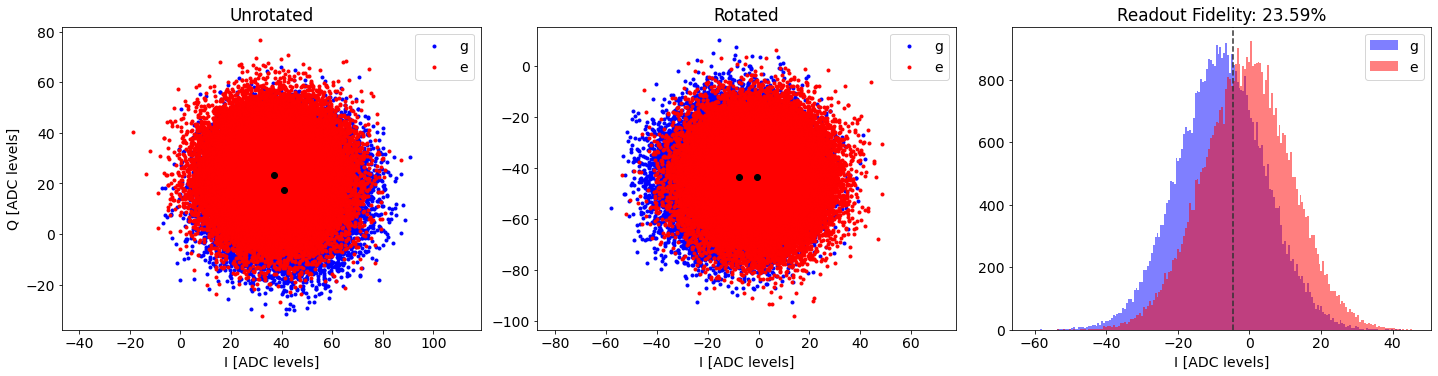

In [335]:
# # TESTING
# shot = meas.HistogramExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00001_single_shot_qubit0.h5')
# data = shot.analyze(data=temp_data)
# shot.display(data=data)

shot.analyze(verbose=False)
shot.display(verbose=True)

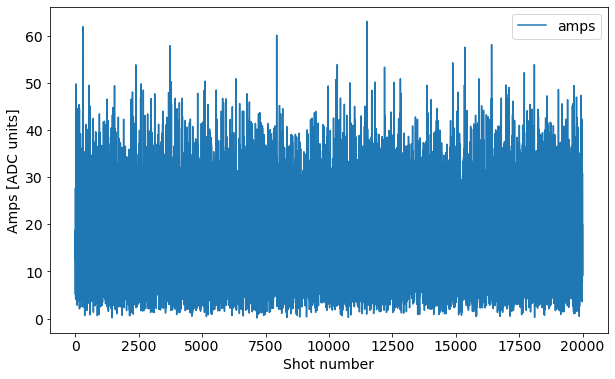

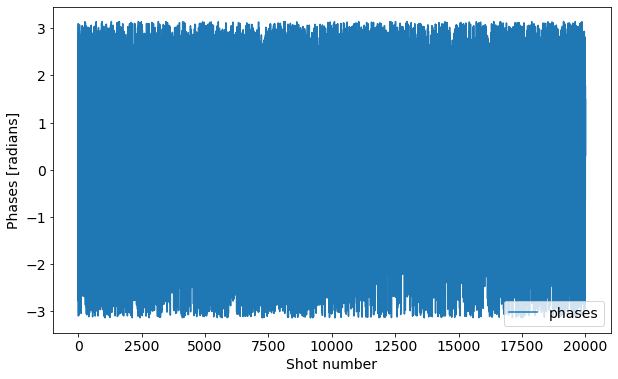

In [88]:
# Checking for drift vs. shot number

data = shot.data
i = data['Ig']
q = data['Qg']
amps = np.abs(i+1j*q)
phases = np.angle(i+1j*q)

plt.plot(amps, label='amps')
plt.ylabel('Amps [ADC units]')
plt.xlabel('Shot number')
plt.legend()
plt.show()

plt.plot(phases, label='phases')
plt.ylabel('Phases [radians]')
plt.xlabel('Shot number')
plt.legend()
plt.show()

In [89]:
shot.save_data()

Saving s:\Connie\experiments\20220430_2Transmon\data\00001_single_shot_qubit0.h5


### Single shot optimization

In [91]:
shotopt = meas.SingleShotOptExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_opt_qubit{qubit_i}",
    config_file=config_path,
)

span_f = 2 # MHz
npts_f = 8

span_gain = 140
# npts_gain = 2
npts_gain = 7

span_len = 15 # us
# npts_len = 2
npts_len = 5

shotopt.cfg.expt = dict(
    reps=100000,
    qubit=qubit_i,

    start_f=shotopt.cfg.device.readout.frequency[qubit_i] - 0.75*span_f,
    step_f=span_f/npts_f,
    expts_f=npts_f,

    # start_gain=int(shotopt.cfg.device.readout.gain[qubit_i] - 0.5*span_gain),
    # start_gain=int(shotopt.cfg.device.readout.gain[qubit_i]-span_gain/2),
    start_gain=150,
    step_gain=int(span_gain/npts_gain),
    expts_gain=npts_gain,

    start_len=10,
    step_len=span_len/npts_len,
    expts_len=npts_len,
)

print(shotopt.cfg)

shotopt.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [50, 35], 'T2R': [13, 20], 'f_ge': [3646.7584779001595, 4536.33065792081], 'f_ef': [3487.35, 4354.3124984175265], 'f_EgGf': 5243.181945338396, 'pulses': {'pi_ge': {'gain': [29284, 2154], 'sigma': [0.3, 0.04], 'type': 'gauss'}, 'pi_ef': {'gain': [24292, 3586], 'sigma': [0.5, 0.02], 'type': 'gauss'}, 'pi_EgGf': {'gain': 15170, 'sigma': 0.4, 'type': 'gauss'}}}, 'readout': {'trig_offset': 180, 'frequency': [552.2, 1751.5253727591987], 'gain': [94, 255], 'phase': [-0.21743215294427692, -3.095165520548619], 'threshold': [72.01127819598226, -2.544007934071093], 'readout_length': [13, 22], 'relax_delay': [200, 150]}}, 'hw': {'lo': {'readout': {'frequency': '5.4e9', 'power': 13}}, 'soc': {'adcs': {'readout': {'ch': [0, 1]}}, 'dacs': {'qubit': {'ch': [3, 1], 'nyquist': [2, 2]}, 'swap': {'ch': 1, 'nyquist': 2}, 'readout': {'ch': [0, 4], 'nyquist': [1, 1]}}}}, 'aliases': {'readout_LO': 'SC26C3', 'soc': 'Qick186'}, 'expt': {'reps': 100000, 'qubit': 1, 'start_f': 1750.025

  0%|          | 0/8 [00:00<?, ?it/s]

In [116]:
shotopt.analyze()
print(shotopt.data['fid'])

(6, 6, 2)
[1750.02537276 1750.27537276 1750.52537276 1750.77537276 1751.02537276
 1751.27537276 1751.52537276 1751.77537276]
[150 170 190 210 230 250 270]
[10. 13. 16. 19. 22.]
Max fidelity 0.23594589864746618
Set params: 
 angle (deg) -4.944448307509958 
 threshold 3.277441669013662 
 freq [Mhz] 1751.5253727591987 
 gain [dac units] 270 
 readout length [us] 16.0
[[[0.01682008 0.01341007 0.01126006 0.01101006 0.01490007]
  [0.01511008 0.01690008 0.01728017 0.01579008 0.01560016]
  [0.01468015 0.01793009 0.01799009 0.01894009 0.0198303 ]
  [0.0196801  0.02366012 0.01772009 0.02299011 0.01835009]
  [0.01798009 0.0193801  0.02228011 0.02124011 0.0196401 ]
  [0.0201102  0.02239011 0.02387024 0.02159011 0.02301012]
  [0.02533013 0.02573039 0.02566026 0.02456025 0.02144011]]

 [[0.02697013 0.02618013 0.02557013 0.02589039 0.02283011]
  [0.02641013 0.02903015 0.02653013 0.02713014 0.02934015]
  [0.03406034 0.03354017 0.02885014 0.03038015 0.02783014]
  [0.03447052 0.0401702  0.03671018 0.038

In [93]:
shotopt.save_data()

Saving s:\Connie\experiments\20220430_2Transmon\data\00001_single_shot_opt_qubit1.h5


## $T_1$

Measures the qubit T1 characteristic decay time by preparing the qubit in its excited state with a $\pi$ pulse followed by a variable delay ($\tau$) before measuring the qubit's state. This exponential decay curve can be fitted in post-processing to obtain the qubit T1 time.

In [307]:
t1 = meas.T1Experiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"t1_qubit{qubit_i}",
    config_file=config_path,
)

span = 200
npts = 151

t1.cfg.expt = dict(
    start=0, # wait time [us]
    step=span/npts,
    expts=npts,
    reps=100,
    rounds=100,
    qubit=qubit_i,
)

t1.cfg.device.readout.relax_delay = 300 # Wait time between experiments [us]

print(t1.cfg)

t1.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [35, 80, 50, 50], 'f_ge': [845.0, 3478.17, 168.08, 465.8], 'pulses': {'pi_ge': {'gain': [10585, 13251, 13657, 12683], 'sigma': [0.035, 0.03, 0.02, 0.015], 'type': 'gauss'}}}, 'readout': {'trig_offset': 120, 'frequency': [600.9, -665.3, -292.1, -130.4], 'gain': [0.085, 0.03, 0.025, 0.07], 'phase': [0, 0, 0, 0], 'threshold_ge': [0, 0, 0, 0], 'threshold_ef': [0, 0, 0, 0], 'readout_length': [5, 5, 5, 5], 'relax_delay': 300}}, 'hw': {'lo': {'readout': {'frequency': '6.1e9', 'power': 10}}, 'soc': {'dacs': {'qubit': {'ch': [0, 5, 0, 0], 'type': ['int4', 'full', 'int4', 'int4'], 'mixer_freq': [4000, 0, 4000, 4000], 'nyquist': [2, 2, 2, 2]}, 'swap': {'ch': [4, -1, 4, 4], 'type': ['full', 'None', 'full', 'full'], 'nyquist': [1, 0, 1, 1]}, 'readout': {'ch': 6, 'type': 'mux4', 'mixer_freq': 985, 'nyquist': 1}}, 'adcs': {'readout': {'ch': [0, 1, 2, 3]}}}}, 'aliases': {'readout_LO': 'SC_26C1', 'soc': 'Qick187'}, 'expt': {'start': 0, 'step': 1.3245033112582782, 'expts': 15

  0%|          | 0/100 [00:00<?, ?it/s]

C:\_Lib\python\slab\datamanagement.py:245: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5py.File.__init__(self, *args, **kwargs)


Extracted data and attrs ['config']
Fit T1 avgi [us]: 78.56199276820836
Fit T1 avgq [us]: 74.62418201104244


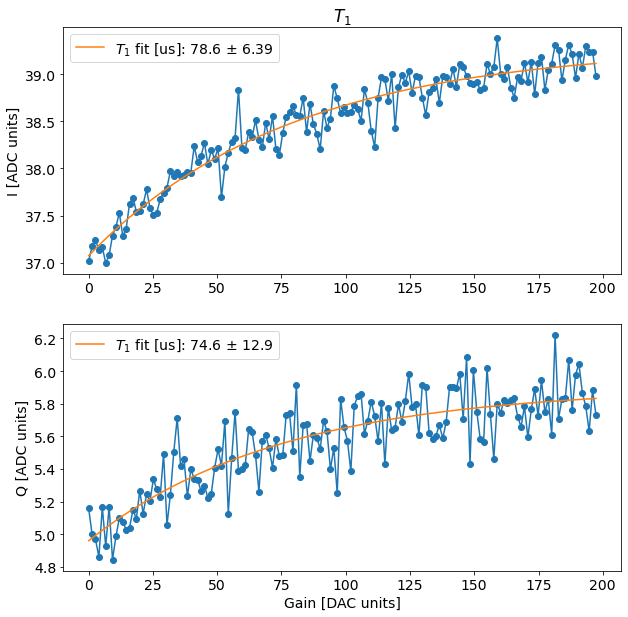

In [367]:
# TESTING
t1 = meas.T1Experiment(config_file=config_path,)
temp_data, attrs = prev_data(expt_path, '00000_t1_qubit1.h5')
data = t1.analyze(data=temp_data, fit=True)
t1.display(data=data, fit=True)

# t1.analyze(fit=True)
# t1.display()

In [315]:
t1.save_data()

Saving s:\Connie\experiments\220623_qram\data\00001_t1_qubit3.h5


## $T_2$ Ramsey Fringe Experiment

Measures the qubit $T_2$ Ramsey characteristic decay time by preparing the qubit in a superposition state with a  $\frac{\pi}{2}$ pulse (about X-axis) followed by a variable delay ($\tau$) before applying another $\frac{\pi}{2}$ pulse (about X-axis) with a phase advanced by $\Delta \phi = \omega * \tau$, where $\omega$ is the Ramsey frequency.

When qubit frequency is off by $\Delta$, oscillations will be observed at $\omega+\Delta$. Iterate on this experiment, adjusting the qubit frequency, until no oscillations are observed.

This exponential decay envelope can be fitted in post-processing to obtain the qubit $T_2$ Ramsey time.

In [591]:
0.5/soc.cycles2us(50)

3.84

In [303]:
t2r = meas.RamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"ramsey_qubit{qubit_i}",
    config_file=config_path,
)

t2r.cfg.expt = dict(
    start=0, # wait time tau [us]
    step=soc.cycles2us(10), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    # step=0.05, # [us]
    expts=151,
    ramsey_freq=2, # [MHz]
    reps=100,
    rounds=100,
    qubit=qubit_i,
)

t2r.cfg.device.readout.relax_delay = 3*t2r.cfg.device.qubit.T1[qubit_i] # Wait time b/w expts [us]

print(t2r.cfg)

t2r.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [35, 80, 50, 50], 'f_ge': [845.0, 3478.17, 168.08, 465.8], 'pulses': {'pi_ge': {'gain': [10585, 13251, 13657, 12683], 'sigma': [0.035, 0.03, 0.02, 0.015], 'type': 'gauss'}}}, 'readout': {'trig_offset': 120, 'frequency': [600.9, -665.3, -292.1, -130.4], 'gain': [0.085, 0.03, 0.025, 0.07], 'phase': [0, 0, 0, 0], 'threshold_ge': [0, 0, 0, 0], 'threshold_ef': [0, 0, 0, 0], 'readout_length': [5, 5, 5, 5], 'relax_delay': 150}}, 'hw': {'lo': {'readout': {'frequency': '6.1e9', 'power': 10}}, 'soc': {'dacs': {'qubit': {'ch': [0, 5, 0, 0], 'type': ['int4', 'full', 'int4', 'int4'], 'mixer_freq': [4000, 0, 4000, 4000], 'nyquist': [2, 2, 2, 2]}, 'swap': {'ch': [4, -1, 4, 4], 'type': ['full', 'None', 'full', 'full'], 'nyquist': [1, 0, 1, 1]}, 'readout': {'ch': 6, 'type': 'mux4', 'mixer_freq': 985, 'nyquist': 1}}, 'adcs': {'readout': {'ch': [0, 1, 2, 3]}}}}, 'aliases': {'readout_LO': 'SC_26C1', 'soc': 'Qick187'}, 'expt': {'start': 0, 'step': 0.028571714288571456, 'expts': 

  0%|          | 0/100 [00:00<?, ?it/s]

Current qubit frequency: 465.8
Fit frequency from I [MHz]: 0.8274071373882088 +/- 0.001209929634594943
Suggested new qubit frequency from fit I [MHz]:
 	466.9725928626118
 	462.9725928626118
T2 Ramsey from fit I [us]: 16.13992137506274
Fit frequency from Q [MHz]: 0.8300330911200118 +/- 0.0030037038935490845
Suggested new qubit frequencies from fit Q [MHz]:
 	466.96996690888
 	462.96996690888
T2 Ramsey from fit Q [us]: 10.986813673012941


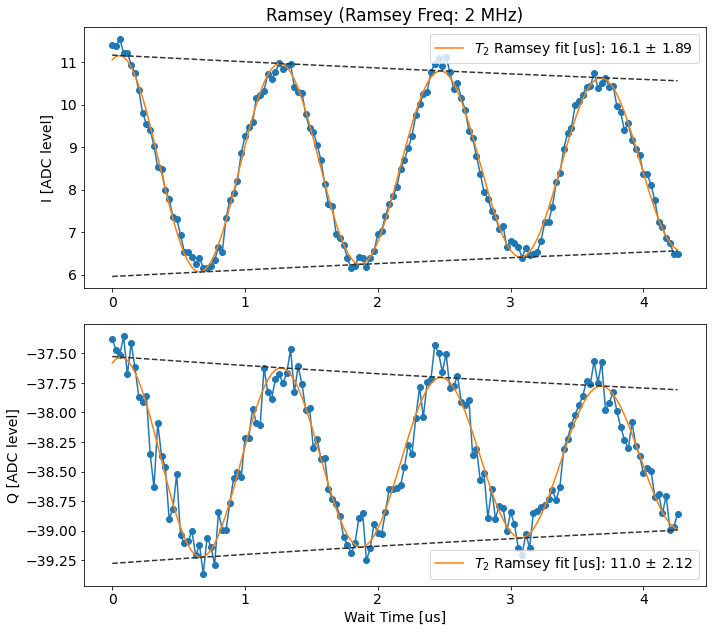

In [317]:
# # TESTING
# t2r = meas.RamseyExperiment(config_file=config_path)
# t2r.cfg.expt = dict(ramsey_freq=1, qubit=qubit_i)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit1.h5')
# data = t2r.analyze(data=temp_data, fit=True)
# t2r.display(data=data, fit=True)

t2r.analyze(fit=True)
t2r.display(fit=True)

In [318]:
t2r.save_data()

Saving s:\Connie\experiments\220623_qram\data\00000_ramsey_qubit3.h5


## $T_2$ Echo

Same idea as Ramsey, but add additional $\pi$ pulses in the middle of $\tau$  which prevent the qubit from decaying as quickly.

In [166]:
0.5/soc.cycles2us(10)

17.499825

In [319]:
t2e = meas.RamseyEchoExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"echo_qubit{qubit_i}",
    config_file=config_path,
)

t2e.cfg.expt = dict(
    start=0, # total wait time b/w the two pi/2 pulses [us]
    step=soc.cycles2us(10), # make sure nyquist freq = 0.5*(1/step) > ramsey (signal) freq!
    expts=151,
    ramsey_freq=0.5, # frequency by which to advance phase [MHz]
    num_pi=1, # number of pi pulses
    cpmg=True, # set either cp or cpmg to True
    cp=False, # set either cp or cpmg to True
    reps=100,
    rounds=100,
    qubit=qubit_i,
)

t2e.cfg.device.readout.relax_delay = 3*t2e.cfg.device.qubit.T1[qubit_i] # Wait time b/w expts [us]

print(t2e.cfg)

t2e.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [35, 80, 50, 50], 'f_ge': [845.0, 3478.17, 168.08, 465.8], 'pulses': {'pi_ge': {'gain': [10585, 13251, 13657, 12683], 'sigma': [0.035, 0.03, 0.02, 0.015], 'type': 'gauss'}}}, 'readout': {'trig_offset': 120, 'frequency': [600.9, -665.3, -292.1, -130.4], 'gain': [0.085, 0.03, 0.025, 0.07], 'phase': [0, 0, 0, 0], 'threshold_ge': [0, 0, 0, 0], 'threshold_ef': [0, 0, 0, 0], 'readout_length': [5, 5, 5, 5], 'relax_delay': 150}}, 'hw': {'lo': {'readout': {'frequency': '6.1e9', 'power': 10}}, 'soc': {'dacs': {'qubit': {'ch': [0, 5, 0, 0], 'type': ['int4', 'full', 'int4', 'int4'], 'mixer_freq': [4000, 0, 4000, 4000], 'nyquist': [2, 2, 2, 2]}, 'swap': {'ch': [4, -1, 4, 4], 'type': ['full', 'None', 'full', 'full'], 'nyquist': [1, 0, 1, 1]}, 'readout': {'ch': 6, 'type': 'mux4', 'mixer_freq': 985, 'nyquist': 1}}, 'adcs': {'readout': {'ch': [0, 1, 2, 3]}}}}, 'aliases': {'readout_LO': 'SC_26C1', 'soc': 'Qick187'}, 'expt': {'start': 0, 'step': 0.028571714288571456, 'expts': 

  0%|          | 0/100 [00:00<?, ?it/s]

Current qubit frequency: 465.8
Fit frequency from I [MHz]: 0.49996849992726905 +/- 0.012138264004456101
Suggested new qubit frequency from fit I [MHz]:
 	465.80003150007275
 	464.80003150007275
T2 Echo from fit I [us]: 7.217080049562858
Fit frequency from Q [MHz]: 0.5034003344317676 +/- 0.0009159147151798774
Suggested new qubit frequencies from fit Q [MHz]:
 	465.79659966556824
 	464.79659966556824
T2 Echo from fit Q [us]: 12.939538199303195


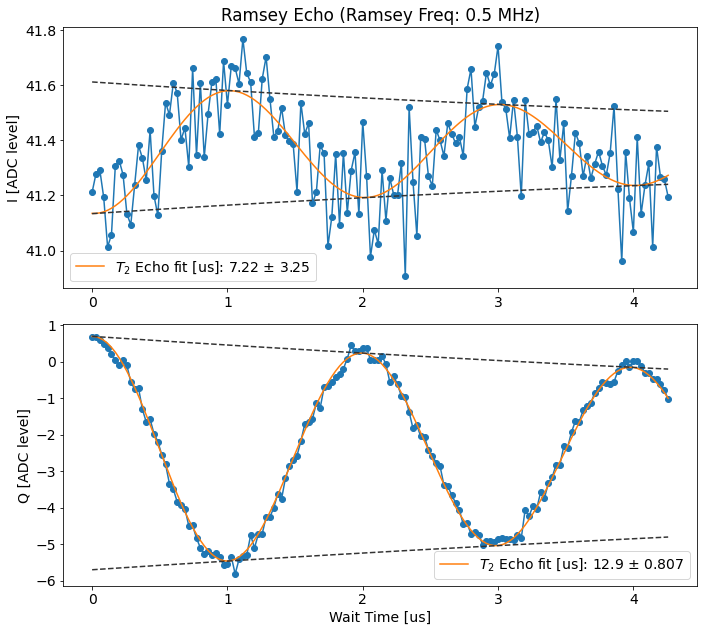

In [320]:
# # TESTING
# t2e = meas.RamseyEchoExperiment(config_file=config_path)
# t2e.cfg.expt = dict(ramsey_freq=1, qubit=qubit_i)
# temp_data, attrs = prev_data(expt_path, '00000_echo_qubit1.h5')
# data = t2e.analyze(data=temp_data, fit=True)
# t2e.display(data=data, fit=True)

t2e.analyze(fit=True)
t2e.display(fit=True)

In [321]:
t2e.save_data()

Saving s:\Connie\experiments\220623_qram\data\00000_echo_qubit3.h5


# Qubit ef spectroscopy

## Pulse Probe ef spectroscopy

Qubit ef frequency should be stored in <code>cfg.qubiti.f_ef</code>.

In [462]:
qEFspec = meas.PulseProbeEFSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_EF_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

span = 125
npts = 125

qEFspec.cfg.expt = dict(
    start=qEFspec.cfg.device.qubit.f_ef[qubit_i]-0.5*span, # resonator frequency to be mixed up [MHz]
    # start=qEFspec.cfg.device.qubit.f_ge[qubit_i] - 50 - span,
    # start=-100,
    step=span/npts, # min step ~1 Hz
    expts=npts, # Number of experiments stepping from start
    reps=300, # Number of averages per point
    rounds=40, # Number of start to finish sweeps to average over
    length=20, # ef probe constant pulse length [us]
    gain=800, # ef pulse gain
    qubit=qubit_i,
)

qEFspec.cfg.device.readout.relax_delay = 5 # Wait time between experiments [us]
print(qEFspec.cfg)

qEFspec.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [35, 80, 50, 44], 'f_ge': [845.0, 3478.17, 168.08, 465.8], 'f_ef': [656.8, 3377, -55, 293], 'pulses': {'pi_ge': {'gain': [10585, 13251, 13657, 12683], 'sigma': [0.035, 0.03, 0.02, 0.015], 'type': 'gauss'}}}, 'readout': {'trig_offset': 120, 'frequency': [600.9, -665.3, -292.1, -130.4], 'gain': [0.085, 0.03, 0.025, 0.07], 'readout_length': [5, 5, 5, 5], 'relax_delay': 5}}, 'hw': {'lo': {'readout': {'frequency': '6.1e9', 'power': 10}}, 'soc': {'dacs': {'qubit': {'ch': [0, 5, 0, 0], 'type': ['int4', 'full', 'int4', 'int4'], 'mixer_freq': [4000, 0, 4000, 4000], 'nyquist': [2, 2, 2, 2]}, 'swap': {'ch': [4, -1, 4, 4], 'type': ['full', 'None', 'full', 'full'], 'nyquist': [1, 0, 1, 1]}, 'readout': {'ch': 6, 'type': 'mux4', 'mixer_freq': 985, 'nyquist': 1}}, 'adcs': {'readout': {'ch': [0, 1, 2, 3]}}}}, 'aliases': {'readout_LO': 'SC_26C1', 'soc': 'Qick187'}, 'expt': {'start': 594.3, 'step': 1.0, 'expts': 125, 'reps': 300, 'rounds': 40, 'length': 20, 'gain': 800, 'qubit

  0%|          | 0/40 [00:00<?, ?it/s]

Found peak in avgi at [MHz] 658.3001181793679, HWHM 7.7585831769775115
Found peak in avgq at [MHz] 658.0679567271959, HWHM 6.043639988081398


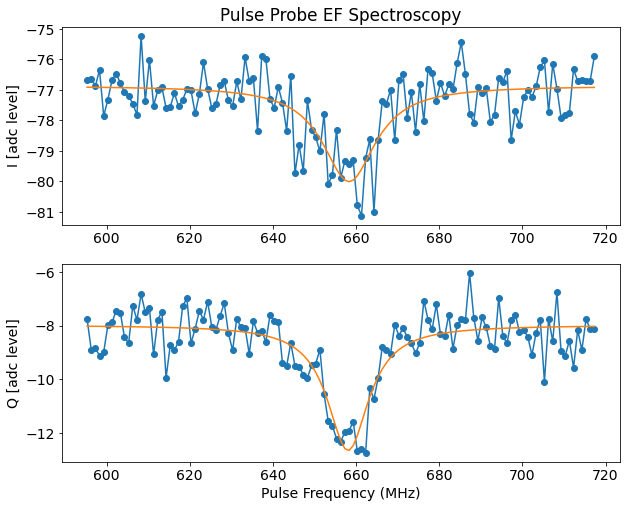

In [465]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = qEFspec.analyze(data=temp_data, fit=True)

qEFspec.analyze(fit=True, signs=[-1, -1])
qEFspec.display(fit=True, signs=[-1, -1])

In [466]:
qEFspec.save_data()

Saving s:\Connie\experiments\220623_qram\data\00000_qubit_EF_spectroscopy_qubit0.h5


### Pulse probe EF power sweep

In [ ]:
pulseprobeEFpowspec = meas.PulseProbeEFPowerSweepSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"pulse_probe_ef_power_sweep_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

span_f = 5
npts_f = 5

span_gain = 1000
npts_gain = 2

pulseprobeEFpowspec.cfg.expt = dict(
    start_f=pulseprobeEFpowspec.cfg.device.readout.frequency[qubit_i]-span_f/2, # Pulse frequency [MHz]
    step_f=span_f/npts_f, # min step ~1 Hz
    expts_f=npts_f, # Number experiments stepping freq from start
    # start_gain=pulseprobeEFpowspec.cfg.device.readout.gain[qubit_i], # Gain sweep start [DAC units]
    start_gain=1,
    step_gain=int(span_gain/npts_gain), # Gain step size
    expts_gain=npts_gain, # Number experiments stepping gain from start
    reps=10,
    rounds=10, # Number averages per point
    length=10, # ef const pulse length [us]
    qubit=qubit_i,
)
pulseprobeEFpowspec.cfg.device.readout.relax_delay = 2*pulseprobeEFpowspec.cfg.device.qubit.T1[qubit_i] # Wait time b/w expts [us]

print(pulseprobeEFpowspec.cfg)

pulseprobeEFpowspec.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = rpowspec.analyze(data=temp_data, lowgain=2000, highgain=18000)

pulseprobeEFpowspec.analyze(lowgain=None, highgain=None)
pulseprobeEFpowspec.display()

In [ ]:
rpowspec.save_data()

## Amplitude EF Rabi

The EF pi pulse amplitude should be stored in <code>cfg.device.qubit.pulses.pi_ef.gain</code>.

In [466]:
amprabiEF = meas.AmplitudeRabiEFExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="amp_rabi_EF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

span = 10000
npts = 15

amprabiEF.cfg.expt = dict(
    start=1, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=20,
    rounds=10,
    sigma_test=0.02, # gaussian sigma for pulse length - default from cfg [us]
    pulse_type='gauss',
    qubit=qubit_i,
)

print(amprabiEF.cfg)
amprabiEF.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [50, 50, 50, 50], 'f_ge': [200, 200, 200, 200], 'f_ef': [200, 200, 200, 200], 'f_EgGf': [2000, 0, 2000, 2000], 'pulses': {'pi_ge': {'gain': [10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_ef': {'gain': [10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_EgGf': {'gain': [10000, 0, 10000, 10000], 'sigma': [0.1, 0, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'trig_offset': 100, 'frequency': [200, 400, 200, 200], 'gain': [-0.8, -0.8, -0.8, -0.8], 'phase': [0, 0, 0, 0], 'threshold': [0, 0, 0, 0], 'readout_length': [20, 20, 20, 20], 'relax_delay': [100, 100, 100, 100]}}, 'hw': {'lo': {'readout': {'frequency': '5.3e9', 'power': 13}}, 'soc': {'dacs': {'qubit': {'ch': [0, 1, 2, 3], 'type': ['int4', 'int4', 'int4', 'int4'], 'mixer_freq': [5300, 3800, 4500, 4900], 'nyquist': [2, 2, 2, 2]}, 'swap': {'ch': [4, -1, 4, 4], 'type': ['full', 'None', 'full', 'full'], 'nyquist': [1, 0, 1, 1]}, 'readout': {'ch': 6

  0%|          | 0/10 [00:00<?, ?it/s]

Pi gain from avgi data [dac units]: 1588
	Pi/2 gain from avgi data [dac units]: 794
Pi gain from avgq data [dac units]: 1895
	Pi/2 gain from avgq data [dac units]: 947


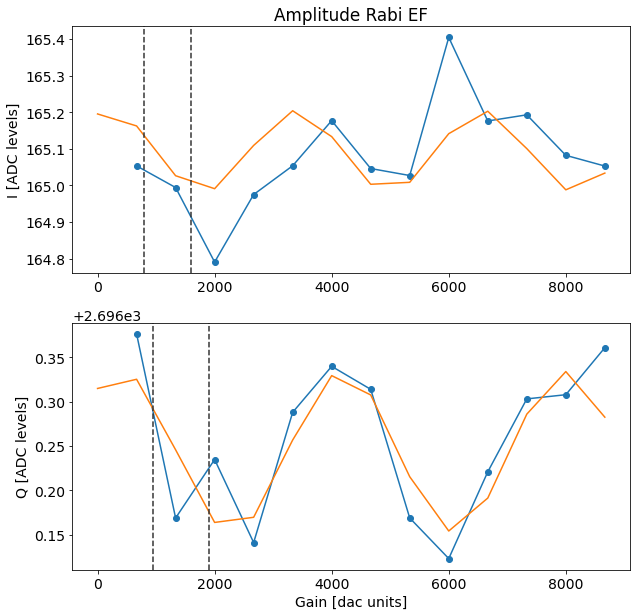

In [467]:
# # TESTING
# amprabiEF = meas.AmplitudeRabiEFExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_ramseyEF_qubit0.h5')
# data = amprabiEF.analyze(data=temp_data, fit=True)
# amprabiEF.display(data=data, fit=True)

amprabiEF.analyze(fit=True)
amprabiEF.display(fit=True)

In [34]:
amprabiEF.save_data()

Saving s:\Connie\experiments\20220430_2Transmon\data\00000_amp_rabi_EF_qubit1.h5


## EF Ramsey Fringe
Update the ef frequency in <code>cfg.qubit.f_ef</code>.

In [468]:
t2EFr = meas.RamseyEFExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="ramseyEF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

t2EFr.cfg.expt = dict(
    start=0, # wait time tau [us]
    step=soc.cycles2us(10), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    # step=0.05, # [us]
    expts=15,
    ramsey_freq=1.5, # [MHz]
    reps=20,
    rounds=20,
    qubit=qubit_i,
)

print(t2EFr.cfg)

t2EFr.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [50, 50, 50, 50], 'f_ge': [200, 200, 200, 200], 'f_ef': [200, 200, 200, 200], 'f_EgGf': [2000, 0, 2000, 2000], 'pulses': {'pi_ge': {'gain': [10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_ef': {'gain': [10000, 10000, 10000, 10000], 'sigma': [0.1, 0.1, 0.1, 0.1], 'type': 'gauss'}, 'pi_EgGf': {'gain': [10000, 0, 10000, 10000], 'sigma': [0.1, 0, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'trig_offset': 100, 'frequency': [200, 400, 200, 200], 'gain': [-0.8, -0.8, -0.8, -0.8], 'phase': [0, 0, 0, 0], 'threshold': [0, 0, 0, 0], 'readout_length': [20, 20, 20, 20], 'relax_delay': [100, 100, 100, 100]}}, 'hw': {'lo': {'readout': {'frequency': '5.3e9', 'power': 13}}, 'soc': {'dacs': {'qubit': {'ch': [0, 1, 2, 3], 'type': ['int4', 'int4', 'int4', 'int4'], 'mixer_freq': [5300, 3800, 4500, 4900], 'nyquist': [2, 2, 2, 2]}, 'swap': {'ch': [4, -1, 4, 4], 'type': ['full', 'None', 'full', 'full'], 'nyquist': [1, 0, 1, 1]}, 'readout': {'ch': 6

  0%|          | 0/20 [00:00<?, ?it/s]

Fit frequency from amps [MHz]: 8.935718332550108
Suggested new EF frequencies from fit amps [MHz]:
 	192.5642816674499
 	189.5642816674499
T2 Ramsey EF from fit amps [us]: 0.2038612082168112


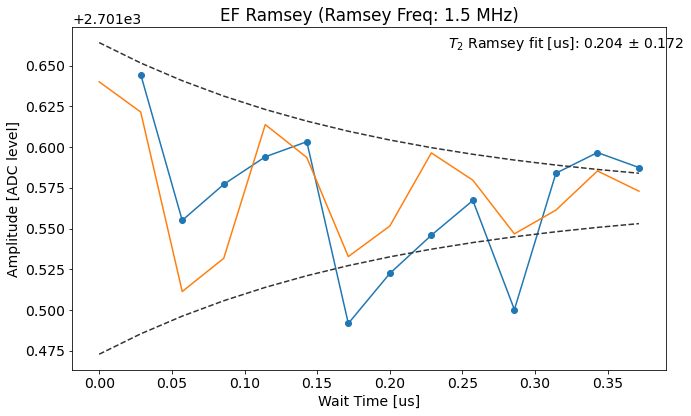

In [469]:
# # TESTING
# t2EFr = meas.RamseyEFExperiment(config_file=config_path)
# t2EFr.cfg.expt = dict(ramsey_freq=1, qubit=qubit_i)
# temp_data = prev_data(expt_path, '00000_ramseyEF_qubit0.h5')
# temp_data = temp_data[0]
# data = t2EFr.analyze(data=temp_data, fit=True)
# t2EFr.display(data=data, fit=True)

t2EFr.analyze(fit=True)
t2EFr.display(fit=True)

In [42]:
t2EFr.save_data()

Saving s:\Connie\experiments\20220430_2Transmon\data\00000_ramseyEF_qubit1.h5
